In [1]:
from tqdm import tqdm
import torch
from torch import nn
import matplotlib.pyplot as plt

In [2]:
import itertools
import dm_env
from dm_env import specs
import numpy as np
from typing import Tuple


class Stimulus:
    def __init__(self, activation_length: int):
        self.active = False
        self.activation_length = activation_length
        self.onset = None
        self.activation_steps = 0

    def set_onset(self, onset):
        self.onset = onset

    def tick(self, time_step):
        if self.active:
            if self.activation_steps >= self.activation_length:
                self.active = False
                self.activation_steps = 0
            self.activation_steps += 1
        else:
            if self.onset == time_step:
                self.active = True
                self.activation_steps = 1

    def get_value(self):
        return int(self.active)


class TraceConditioning(dm_env.Environment):
    def __init__(self, seed: int, ISI_interval: Tuple[int, int], ITI_interval: Tuple[int, int], gamma: float,
                 num_distractors: int, activation_lengths: dict):
        self.num_US = 1
        self.num_CS = 1

        self.ISI_interval = ISI_interval
        self.ITI_interval = ITI_interval
        self.gamma = gamma

        self.US = Stimulus(activation_lengths["US"])
        self.CS = Stimulus(activation_lengths["CS"])

        self.num_distractors = num_distractors
        self.distractors_probs = 1. / np.arange(10, 110, 10)
        self.distractors = [Stimulus(activation_lengths["distractor"]) for _ in range(self.num_distractors)]

        self.time_step = None
        self.trial_start = None
        self.rand_num_generator = np.random.RandomState(seed)

    def reset(self):
        self.time_step = 0
        self.trial_start = 0
        self.configure_trial()
        self.configure_distractors()
        self.tick()
        return dm_env.restart(self.observation())

    def step(self, _):
        self.time_step += 1
        if self.time_step == self.trial_start:
            self.configure_trial()
        self.configure_distractors()
        self.tick()
        return dm_env.TimeStep(dm_env.StepType.MID, self.cumulant(), self.gamma,
                               self.observation())

    def configure_trial(self):
        self.CS.set_onset(self.time_step)
        ISI = self.rand_num_generator.randint(self.ISI_interval[0], self.ISI_interval[1] + 1)
        self.US.set_onset(self.time_step + ISI)
        ITI = self.rand_num_generator.randint(self.ITI_interval[0], self.ITI_interval[1] + 1)
        self.trial_start = self.time_step + ISI + ITI

    def configure_distractors(self):
        for d, distractor in enumerate(self.distractors):
            if (not distractor.active) and self.rand_num_generator.rand() < self.distractors_probs[d]:
                distractor.set_onset(self.time_step)

    def tick(self):
        self.US.tick(self.time_step)
        self.CS.tick(self.time_step)
        for d, distractor in enumerate(self.distractors):
            distractor.tick(self.time_step)

    def cumulant(self):
        return self.US.get_value()

    def observation(self):
        observations = np.zeros(self.num_US + self.num_CS + self.num_distractors)
        observations[0] = self.US.get_value()
        observations[1] = self.CS.get_value()
        for d, distractor in enumerate(self.distractors):
            observations[d + self.num_US + self.num_CS] = distractor.get_value()
        return observations

    def observation_spec(self):
        return specs.BoundedArray(shape=(self.num_US + self.num_CS + self.num_distractors),
                                  dtype=np.float32,
                                  name="observation",
                                  minimum=0,
                                  maximum=1)

    def action_spec(self):
        return specs.DiscreteArray(
            dtype=int, num_values=0, name="action")


class TracePatterning(dm_env.Environment):
    def __init__(
            self, seed: int, ISI_interval: Tuple[int, int], ITI_interval: Tuple[int, int], gamma: float, num_CS: int,
            num_activation_patterns: int, activation_patterns_prob: float, num_distractors: int,
            activation_lengths: dict, noise: float):

        self.num_US = 1
        self.US = Stimulus(activation_lengths["US"])

        self.num_CS = num_CS
        self.CSs = [Stimulus(activation_lengths["CS"]) for _ in range(self.num_CS)]

        self.num_distractors = num_distractors
        self.distractors = [Stimulus(activation_lengths["distractor"]) for _ in range(self.num_distractors)]

        self.num_activation_patterns = num_activation_patterns
        self.activation_patterns_prob = activation_patterns_prob
        self.rand_num_generator = np.random.RandomState(seed)
        self.activation_patterns = produce_activation_patterns(self.rand_num_generator, self.num_CS,
                                                               self.num_activation_patterns)
        self.p = ((2 ** self.num_CS) * self.activation_patterns_prob - self.num_activation_patterns) / \
                 (2 ** self.num_CS - self.num_activation_patterns)

        self.ISI_interval = ISI_interval
        self.ITI_interval = ITI_interval
        self.gamma = gamma
        self.noise = noise

        self.time_step = None
        self.trial_start = None

    def reset(self):
        self.trial_start = 0
        self.time_step = 0
        self.configure_trial()
        self.tick()
        return dm_env.restart(self.observation())

    def step(self, _):
        self.time_step += 1
        if self.time_step == self.trial_start:
            self.configure_trial()
        self.tick()
        return dm_env.TimeStep(dm_env.StepType.MID, self.cumulant(), self.gamma,
                               self.observation())

    def configure_trial(self):
        CS_pattern = self.set_CSs()
        ISI = self.rand_num_generator.randint(self.ISI_interval[0], self.ISI_interval[1] + 1)
        self.set_US(ISI, CS_pattern)
        self.set_distractors()
        ITI = self.rand_num_generator.randint(self.ITI_interval[0], self.ITI_interval[1] + 1)
        self.trial_start = self.time_step + ISI + ITI

    def set_CSs(self):
        if self.rand_num_generator.rand() < self.p:
            CS_pattern = self.activation_patterns[self.rand_num_generator.choice(self.num_activation_patterns), :]
        else:
            CS_pattern = np.ndarray.astype((self.rand_num_generator.randint(2, size=self.num_CS)), dtype=float)
        for c, CS in enumerate(self.CSs):
            if CS_pattern[c] == 1:
                CS.set_onset(self.time_step)
        return CS_pattern

    def set_US(self, ISI, CS_pattern):
        if np.sum(binary_match(CS_pattern, self.activation_patterns)) > 0:
            if self.rand_num_generator.rand() > self.noise:
                self.US.set_onset(self.time_step + ISI)
        else:
            if self.rand_num_generator.rand() < self.noise:
                self.US.set_onset(self.time_step + ISI)

    def set_distractors(self):
        distractor_pattern = np.ndarray.astype((self.rand_num_generator.randint(2, size=self.num_distractors)),
                                               dtype=float)
        for d, distractor in enumerate(self.distractors):
            if distractor_pattern[d]:
                distractor.set_onset(self.time_step)

    def tick(self):
        for c, CS in enumerate(self.CSs):
            CS.tick(self.time_step)
        self.US.tick(self.time_step)
        for d, distractor in enumerate(self.distractors):
            distractor.tick(self.time_step)

    def cumulant(self):
        return self.US.get_value()

    def observation(self):
        observations = np.zeros(self.num_US + self.num_CS + self.num_distractors)
        observations[0] = self.US.get_value()
        for c, CS in enumerate(self.CSs):
            observations[c + 1] = CS.get_value()
        for d, distractor in enumerate(self.distractors):
            observations[d + self.num_CS + self.num_US] = distractor.get_value()
        return observations

    def observation_spec(self):
        return specs.BoundedArray(shape=(self.num_US + self.num_CS + self.num_distractors),
                                  dtype=np.float32,
                                  name="observation",
                                  minimum=0,
                                  maximum=1)

    def action_spec(self):
        return specs.DiscreteArray(
            dtype=int, num_values=0, name="action")


class NoisyPatterning(TracePatterning):
    def __init__(
            self, seed: int, ISI_interval: Tuple[int, int], ITI_interval: Tuple[int, int], gamma: float, num_CS: int,
            num_activation_patterns: int, activation_patterns_prob: float, num_distractors: int,
            activation_lengths: dict, noise: float):
        super().__init__(seed, ISI_interval, ITI_interval, gamma, num_CS, num_activation_patterns,
                         activation_patterns_prob, num_distractors, activation_lengths, noise)
        self.ISI_interval = (activation_lengths["CS"], activation_lengths["CS"])


def compute_return_error(cumulants, predictions, gamma):
    num_time_steps = len(cumulants)
    returns = np.zeros(num_time_steps)
    returns[-1] = cumulants[-1]
    for t in range(num_time_steps - 2, -1, -1):
        returns[t] = gamma * returns[t + 1] + cumulants[t]
    return_error = (predictions - returns) ** 2
    MSRE = return_error.mean()
    return MSRE, return_error, returns


def produce_activation_patterns(rand_num_generator, num_CS, num_activation_patterns):
    activated_indices = list(itertools.combinations(np.arange(num_CS), int(num_CS / 2)))
    selected_indices = rand_num_generator.choice(np.arange(len(activated_indices)), size=num_activation_patterns,
                                                 replace=False)
    activation_patterns = np.zeros((num_activation_patterns, num_CS))
    for i in range(num_activation_patterns):
        activation_patterns[i, activated_indices[selected_indices[i]]] = 1.0
    return activation_patterns


def binary_match(x, patterns):
    if sum(x) == 0:
        ones_match = np.ones(patterns.shape[0])
    else:
        ones_match = np.floor(np.dot(patterns, x) / sum(x))
    if sum(1 - x) == 0:
        zeros_match = np.ones(patterns.shape[0])
    else:
        zeros_match = np.floor(np.dot(1 - patterns, 1 - x) / sum(1 - x))
    return ones_match * zeros_match


In [3]:
cfg = {
    'NUM_CS' : 1,
    'NUM_US' : 1,
    'NUM_DIST' : 0,
    'ISI_interval' : (3,7),
    'ITI_interval' : (80,120),
    'LEN_CS' : 4,
    'LEN_US' : 2,
    'LEN_DIST' : 4,
    'ADAMB1' : 0.9,
    'ADAMB2' : 0.999,
    'ADAME' : 10e-8,
    'LAMBDA' : 0,
    'N_TRAIN_STEPS' : 40000,
    'TBPTT_T' : 10,
    'HIDDEN_L_SIZE' : 10,
    'STEP_SIZE' : 1e-4,
    'INITIAL_STEPS': 100,
}
cfg['GAMMA'] = 1-1/np.mean(cfg['ISI_interval'])

In [4]:
def plot_last_n(obsall, predall, errors=None, n=1000):
    nobs = cfg['NUM_CS'] + cfg['NUM_US'] + cfg['NUM_DIST']

    fig, axs = plt.subplots(nobs+3,figsize=(30, 35))
    fig.tight_layout()
    for i in range(nobs):
        axs[i].plot(list(range(n)), obsall[:, i][-n:])

    if errors is not None:
        axs[-3].plot(list(range(n)), errors[2][-n:] )
        axs[-2].plot(list(range(n)), predall[-n:] )
        axs[-1].plot(list(range(n)), errors[1][-n:])
        print(f'MSE: {errors[0]}')

    axs[0].title.set_text('US')
    axs[1].title.set_text('CS')
    axs[-3].title.set_text('return target')
    axs[-2].title.set_text('return prediction')
    axs[-1].title.set_text('return error')
    for ax in axs:
        ax.grid(color='#666666', linestyle='-', alpha=0.5)

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [6]:
class LSTM_V(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(input_size = cfg['NUM_CS'] + cfg['NUM_US'] + cfg['NUM_DIST'],
                            hidden_size = cfg['HIDDEN_L_SIZE'],
                            num_layers = 1,
                            dropout = 0)
        self.linear = nn.Linear(cfg['HIDDEN_L_SIZE'], 1)
        self.hidden = (torch.randn(1, 1, cfg['HIDDEN_L_SIZE']).to(device),
                       torch.randn(1, 1, cfg['HIDDEN_L_SIZE']).to(device))
        self.hidden_0 = self.hidden # used to save (h_0, c_0) of last batch
        
    def reset_hidden(self):
        self.hidden = (torch.randn(1, 1, cfg['HIDDEN_L_SIZE']).to(device),
                       torch.randn(1, 1, cfg['HIDDEN_L_SIZE']).to(device)) 
        
    def forward(self, obs):
        obs = obs.view(len(obs), 1, -1)
        lstm_out_0, self.hidden = self.lstm(obs[0].view(1,1,-1), self.hidden_0)
        
        # save the hidden state (h_0 and c_0) of first element for when the LSTM is called
        # so that it can be used when a new batch is passed in
        self.hidden_0 = (self.hidden[0].detach(), self.hidden[1].detach())

        lstm_out, self.hidden = self.lstm(obs[1:], self.hidden)
        lstm_out = torch.cat((lstm_out_0, lstm_out))
        
        # hidden_size -> 1 for each obs
        values = self.linear(lstm_out.view(len(obs), -1))
        return values

In [7]:
tc = TraceConditioning(seed=2,
                       ISI_interval=cfg['ISI_interval'],
                       ITI_interval=cfg['ITI_interval'],
                       gamma=cfg['GAMMA'],
                       num_distractors=cfg['NUM_DIST'],
                       activation_lengths={'CS': cfg['LEN_CS'], 'US': cfg['LEN_US'], 'distractor':cfg['LEN_DIST']})

In [8]:
model = LSTM_V().to(device)
loss = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), 
                             lr=cfg['STEP_SIZE'],
                             betas=[cfg['ADAMB1'], 
                                    cfg['ADAMB2']], 
                             eps=cfg['ADAME'])


In [9]:
def train_td(env, model, loss, optimizer):
    state = env.reset()
    obsall = np.zeros((cfg['N_TRAIN_STEPS'], state.observation.shape[0],))
    predall = np.zeros((cfg['N_TRAIN_STEPS']))
    t = -1
    # take 100 steps at start
    for i in range(cfg['INITIAL_STEPS']):
        t += 1
        step = env.step(_)
        obsall[t] = step.observation
        predall[t] = 0

    for i in tqdm(range(cfg['N_TRAIN_STEPS'] - cfg['INITIAL_STEPS'])):
        t += 1
        step_new = env.step(_)
        obsall[t] = step_new.observation

        # get V_t-T .... V_t.
        V_t = model(torch.FloatTensor(obsall[t-cfg['TBPTT_T']: t+1]).to(device))

        # get the next step prediction (V_t+1) for each step (V_t)
        V_tp1 = V_t[1:]
        # get the reward obtained (US_t+1) for going to next step
        US_tp1 = torch.tensor(
            obsall[t-cfg['TBPTT_T']+1: t+1][:,0]
        ).view(-1,1).to(device)

        # dont use gradient when calculating the TD target
        # For each value prediction V_t at step t, we use US_t+1 and V_t+1 to calculate TD target
        with torch.no_grad():
            td_target = US_tp1 + cfg['GAMMA'] * V_tp1

        # V_t also includes the prediction for o_t, so we remove it from here.
        # It is only used to calculate the TD target for o_t-1 previously
        td_error = loss(V_t[:-1], td_target.float())
        td_error.backward()
        optimizer.step()

        if i % 1000 == 0:
            print(f'TD Error at t:{i} = {td_error}')

        # Store the value prediction belonging to o_t
        predall[t] = V_tp1[-1].detach().item()
        
    return obsall, predall

In [10]:
obsall, predall = train_td(tc, model, loss, optimizer)
errors = compute_return_error(obsall[:,0], predall, cfg['GAMMA'])

  0%|          | 129/39900 [00:00<01:01, 647.93it/s]

TD Error at t:0 = 0.09583814442157745


  3%|▎         | 1127/39900 [00:01<00:56, 682.91it/s]

TD Error at t:1000 = 2.1583389752777293e-05


  5%|▌         | 2146/39900 [00:03<00:51, 729.22it/s]

TD Error at t:2000 = 0.00021072693925816566


  8%|▊         | 3093/39900 [00:04<00:51, 709.28it/s]

TD Error at t:3000 = 0.03694143891334534


 10%|█         | 4112/39900 [00:05<00:48, 731.83it/s]

TD Error at t:4000 = 0.000366038380889222


 13%|█▎        | 5143/39900 [00:07<00:48, 723.76it/s]

TD Error at t:5000 = 0.0003190675051882863


 15%|█▌        | 6106/39900 [00:08<00:45, 738.20it/s]

TD Error at t:6000 = 0.0006079530576243997


 18%|█▊        | 7129/39900 [00:09<00:45, 722.14it/s]

TD Error at t:7000 = 2.824461626005359e-05


 20%|██        | 8078/39900 [00:11<00:44, 715.58it/s]

TD Error at t:8000 = 0.000405623868573457


 23%|██▎       | 9086/39900 [00:12<00:43, 715.30it/s]

TD Error at t:9000 = 0.0003294379566796124


 25%|██▌       | 10114/39900 [00:14<00:41, 713.75it/s]

TD Error at t:10000 = 5.461820819618879e-06


 28%|██▊       | 11141/39900 [00:15<00:39, 722.59it/s]

TD Error at t:11000 = 0.00010876921442104504


 30%|███       | 12081/39900 [00:16<00:38, 724.71it/s]

TD Error at t:12000 = 4.011832788819447e-05


 33%|███▎      | 13100/39900 [00:18<00:36, 725.15it/s]

TD Error at t:13000 = 6.905506597831845e-05


 35%|███▌      | 14119/39900 [00:19<00:35, 729.67it/s]

TD Error at t:14000 = 0.0013591728638857603


 38%|███▊      | 15139/39900 [00:21<00:34, 723.90it/s]

TD Error at t:15000 = 0.00041500161751173437


 40%|████      | 16082/39900 [00:22<00:33, 712.44it/s]

TD Error at t:16000 = 0.00033105278271250427


 43%|████▎     | 17090/39900 [00:23<00:31, 729.90it/s]

TD Error at t:17000 = 0.00022612301108893007


 45%|████▌     | 18111/39900 [00:25<00:29, 729.95it/s]

TD Error at t:18000 = 0.0018171732081100345


 48%|████▊     | 19141/39900 [00:26<00:28, 721.86it/s]

TD Error at t:19000 = 0.0008867716533131897


 50%|█████     | 20086/39900 [00:28<00:27, 727.60it/s]

TD Error at t:20000 = 0.0012851423816755414


 53%|█████▎    | 21105/39900 [00:29<00:25, 733.17it/s]

TD Error at t:21000 = 2.111828507622704e-06


 55%|█████▌    | 22057/39900 [00:30<00:25, 701.81it/s]

TD Error at t:22000 = 1.6403002689457935e-07


 58%|█████▊    | 23106/39900 [00:32<00:23, 716.97it/s]

TD Error at t:23000 = 0.06928103417158127


 60%|██████    | 24098/39900 [00:33<00:22, 690.42it/s]

TD Error at t:24000 = 7.674093467358034e-07


 63%|██████▎   | 25114/39900 [00:35<00:20, 725.38it/s]

TD Error at t:25000 = 9.167951247945894e-06


 66%|██████▌   | 26140/39900 [00:36<00:18, 724.48it/s]

TD Error at t:26000 = 0.0003663022362161428


 68%|██████▊   | 27078/39900 [00:38<00:17, 715.81it/s]

TD Error at t:27000 = 0.0002909096365328878


 70%|███████   | 28105/39900 [00:39<00:16, 717.92it/s]

TD Error at t:28000 = 0.00011876283679157495


 73%|███████▎  | 29128/39900 [00:40<00:14, 721.80it/s]

TD Error at t:29000 = 3.384773663128726e-05


 76%|███████▌  | 30147/39900 [00:42<00:13, 728.77it/s]

TD Error at t:30000 = 6.44434621790424e-05


 78%|███████▊  | 31088/39900 [00:43<00:12, 693.81it/s]

TD Error at t:31000 = 0.00017472545732744038


 80%|████████  | 32107/39900 [00:45<00:10, 730.51it/s]

TD Error at t:32000 = 0.00019014881399925798


 83%|████████▎ | 33132/39900 [00:46<00:09, 697.70it/s]

TD Error at t:33000 = 0.0841360092163086


 85%|████████▌ | 34083/39900 [00:47<00:07, 734.38it/s]

TD Error at t:34000 = 0.0001963706308742985


 88%|████████▊ | 35106/39900 [00:49<00:06, 728.02it/s]

TD Error at t:35000 = 1.9271037672297098e-06


 91%|█████████ | 36135/39900 [00:50<00:05, 729.90it/s]

TD Error at t:36000 = 2.2221538529265672e-05


 93%|█████████▎| 37082/39900 [00:52<00:03, 716.34it/s]

TD Error at t:37000 = 4.489966158871539e-05


 96%|█████████▌| 38111/39900 [00:53<00:02, 731.69it/s]

TD Error at t:38000 = 6.965945067349821e-05


 98%|█████████▊| 39140/39900 [00:54<00:01, 720.61it/s]

TD Error at t:39000 = 0.00018883011944126338


100%|██████████| 39900/39900 [00:56<00:00, 712.46it/s]


MSE: 0.04190517299648628


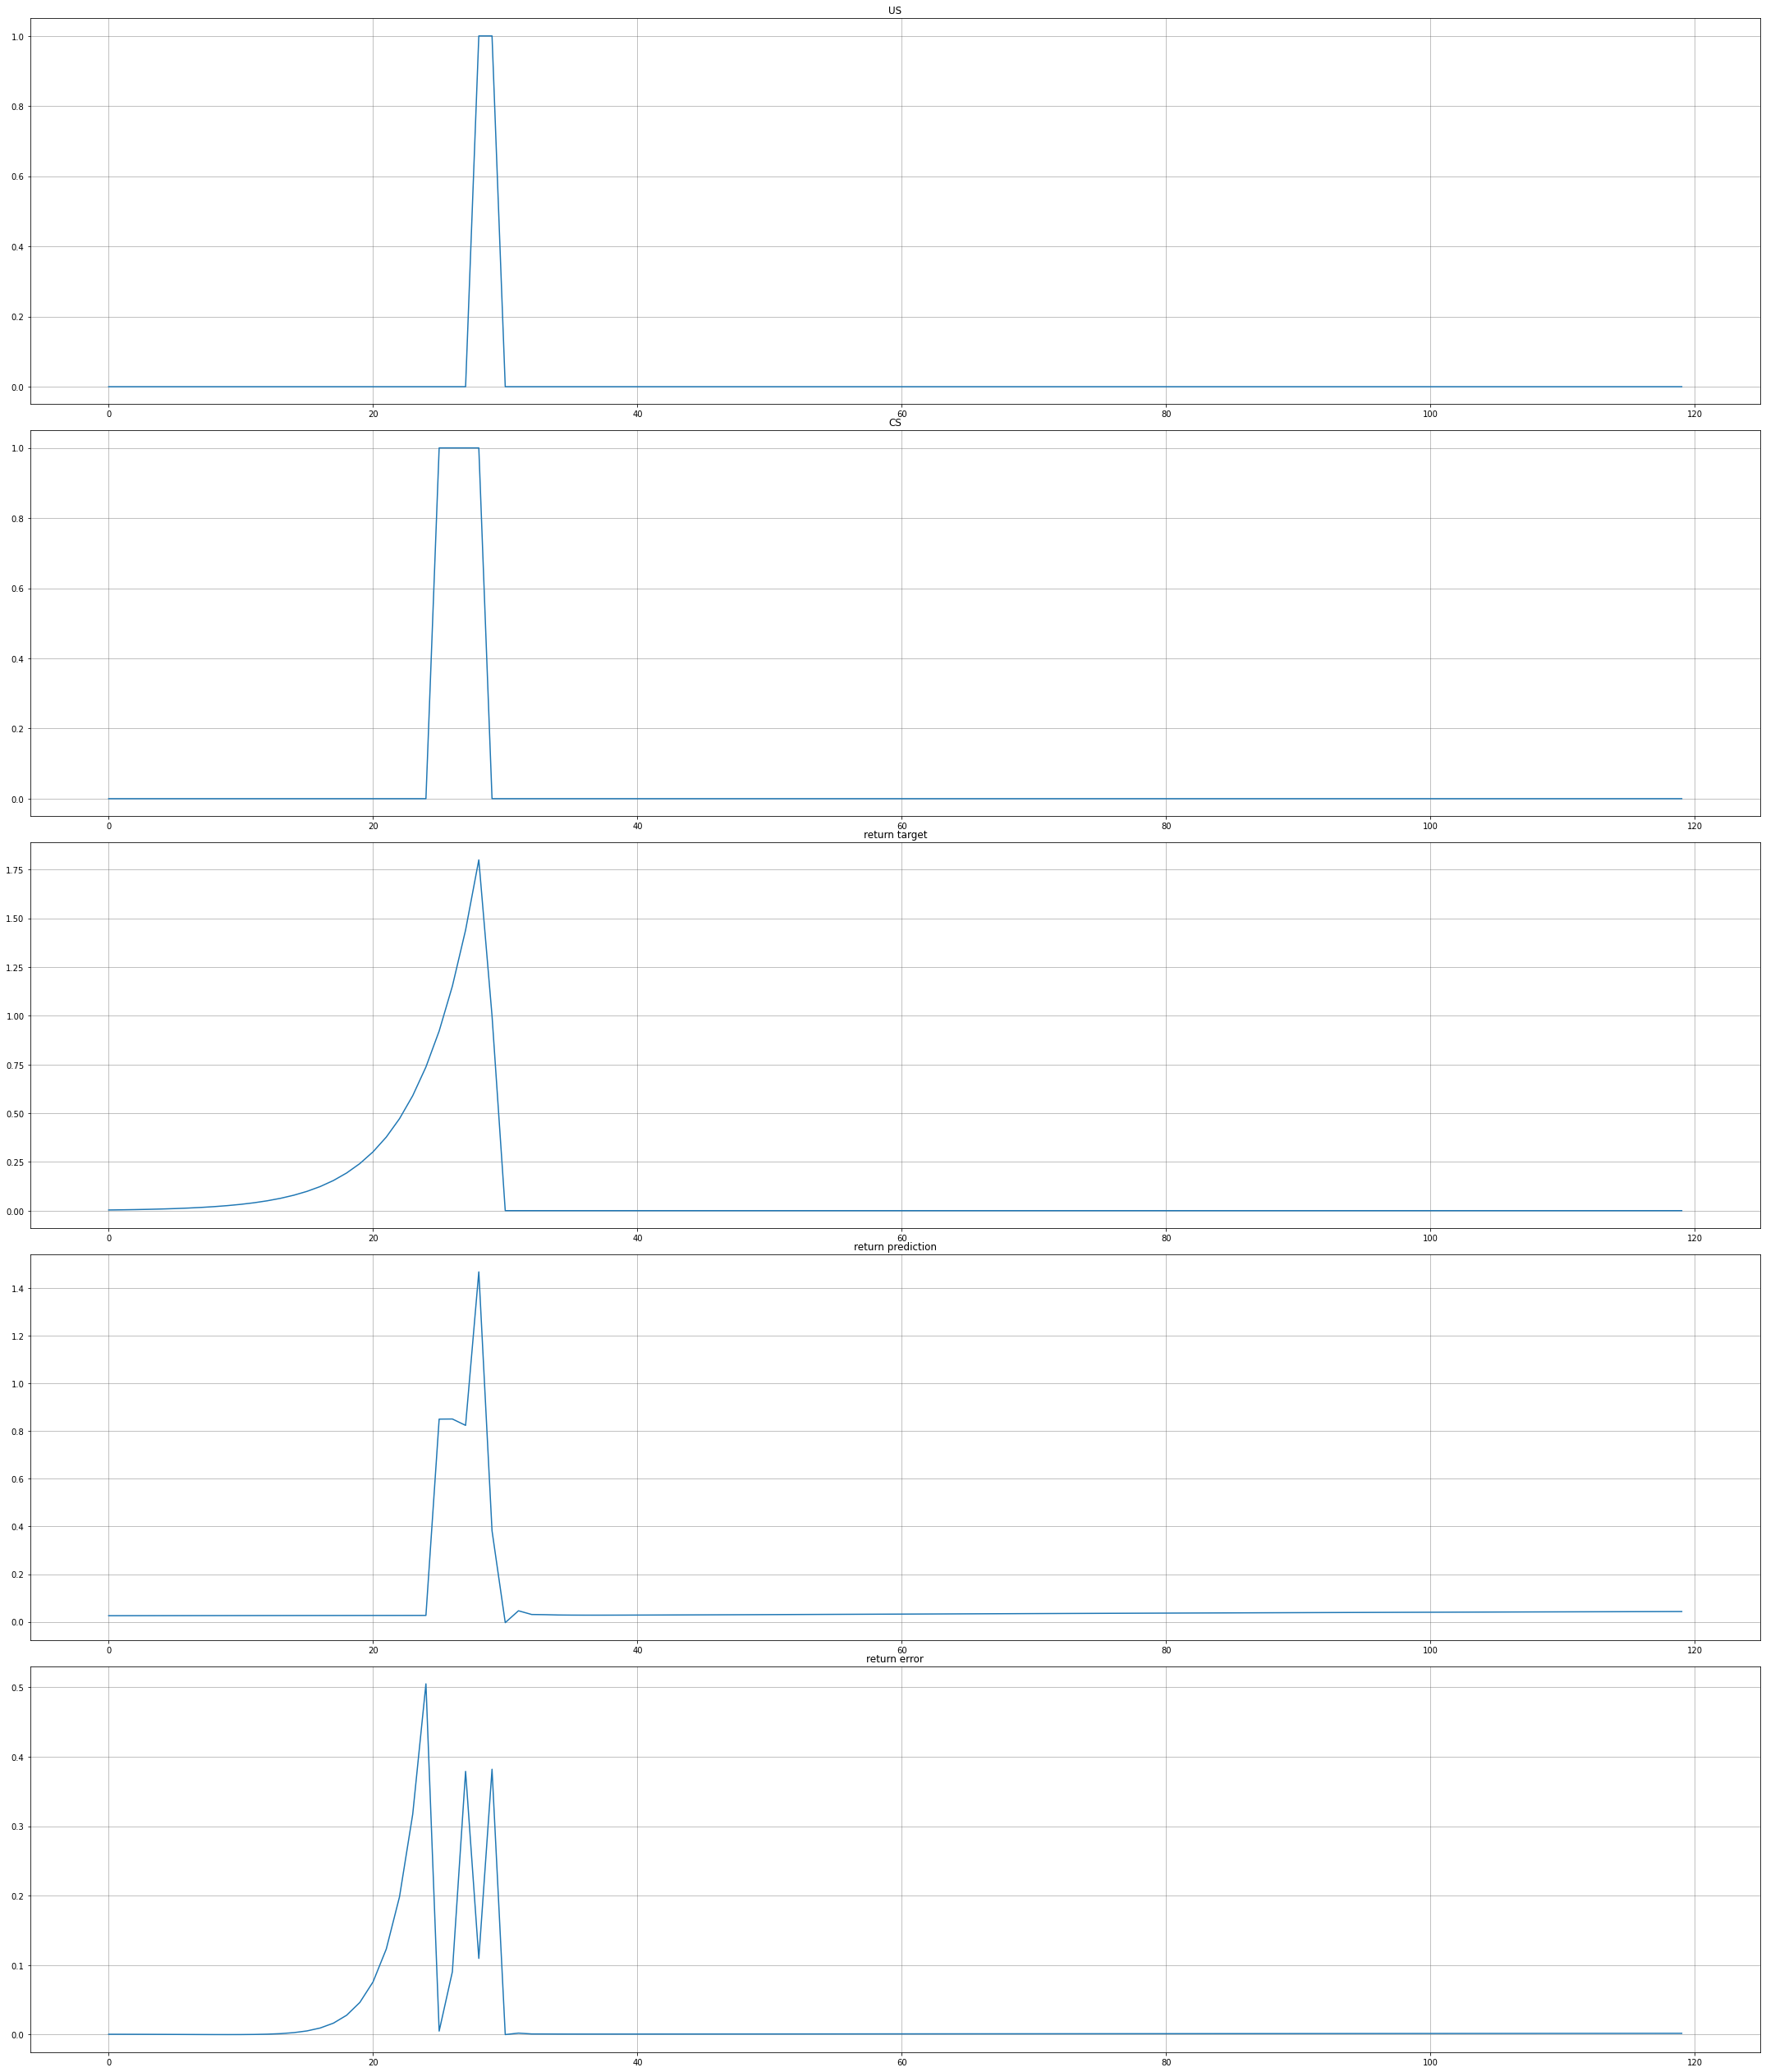

In [11]:
plot_last_n(obsall, predall, errors, n=120)